In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# **Library**

In [34]:
import warnings
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.graph_objects as go
from bs4 import BeautifulSoup
from urllib.request import urlopen



In [35]:
# color pallette and font size
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow
font_size = 20

# Uploading Data to Dataframe

In [36]:
age_group = pd.read_csv('/kaggle/input/covid19-in-india/AgeGroupDetails.csv')

#Data scrapping from www.mohfw.gov.in, cleaning data, creating new calculated column 'Active'
url = "https://www.mohfw.gov.in/"
dfs = pd.read_html(url)
for covid19_india in dfs:
    covid19_india
covid19_india = covid19_india.iloc[:32,:]
col_list=['S_no','State_UnionTeritory','Confirmed_cases','Cured','Death']
covid19_india.columns = col_list
convert_dict = {'S_no': int,'Confirmed_cases': int,'Cured':int,'Death':int}
covid19_india = covid19_india.astype(convert_dict)
covid19_india['Active'] = covid19_india['Confirmed_cases']-covid19_india['Cured']+covid19_india['Death']

india_df = pd.read_csv('/kaggle/input/covid19-in-india/covid_19_india.csv')

patient_data = pd.read_csv('/kaggle/input/covid19-corona-virus-india-dataset/patients_data.csv')

testing_df = pd.read_csv('/kaggle/input/icmr-testing-data/testing data.csv')

# Data Cleaning

In [37]:
india_df=india_df.drop(columns=['ConfirmedIndianNational','ConfirmedForeignNational'],axis=1)
india_df['Date']=pd.to_datetime(india_df['Date'],format='%d/%m/%y')

# Overall view of the Covid19 Situation in India

# **Overall count in India**

In [38]:
df_temp=covid19_india.drop(columns=['S_no', 'State_UnionTeritory'],axis=1)
df_temp=pd.DataFrame(df_temp.sum()).transpose()
df_temp['CFR(%)'] = (df_temp.Death/df_temp.Confirmed_cases)*100
df_temp['Date']=(date.today().strftime("%B %d, %Y"))
df_temp.set_index('Date',inplace=True)
df_temp.style.background_gradient(cmap='RdBu',axis=1)

,Confirmed_cases,Cured,Death,Active,CFR(%)
Date,,,,,
"April 24, 2020",23077,4749,718,19046,3.11132


In [39]:
fig = px.pie(age_group,values=age_group.TotalCases,names=age_group.AgeGroup,
             title='Total Cases-Age wise distribution in India',
            color_discrete_sequence=px.colors.sequential.Plasma)
fig.show()

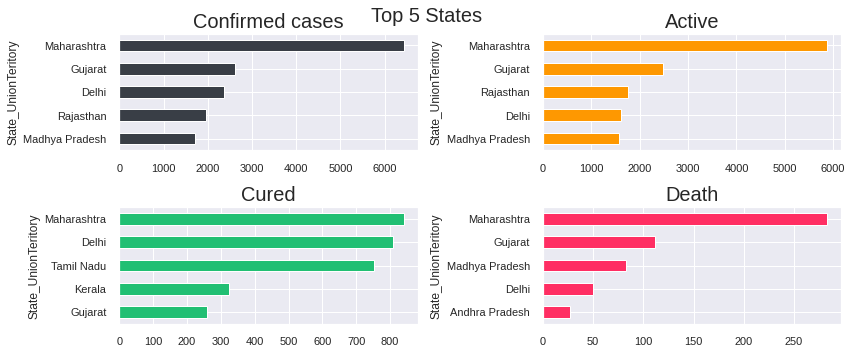

In [40]:
df_temp = covid19_india.set_index('State_UnionTeritory')
fig , ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(12,5))

df_temp.Confirmed_cases.sort_values()[-5:].plot(kind='barh',ax=ax1,color=cnf)
ax1.set_title('Confirmed cases',fontsize=font_size)
df_temp.Active.sort_values()[-5:].plot(kind='barh',ax=ax2,color=act)
ax2.set_title('Active',fontsize=font_size)
df_temp.Cured.sort_values()[-5:].plot(kind='barh',ax=ax3,color=rec)
ax3.set_title('Cured',fontsize=font_size)
df_temp.Death.sort_values()[-5:].plot(kind='barh',ax=ax4,color=dth)
ax4.set_title('Death',fontsize=font_size)


plt.style.use('seaborn')
fig.suptitle('Top 5 States',fontsize=font_size)
plt.tight_layout()
warnings.simplefilter('ignore')

In [41]:
df_temp= india_df.groupby('Date')['Confirmed'].sum().reset_index().sort_values('Date')
df_temp['New_cases']=df_temp['Confirmed'].diff().fillna(method='bfill')
df_temp['New_cases']=df_temp['New_cases'].astype(int)

fig = px.bar(df_temp,x='Date',y='New_cases')
fig.update_layout(title_text="Daily new cases")
fig.show()

In [42]:
df_temp= india_df.groupby('Date')['Cured'].sum().reset_index().sort_values('Date')
df_temp['Daily_cured']=df_temp['Cured'].diff().fillna(method='bfill')
df_temp['Daily_cured']=df_temp['Daily_cured'].astype(int)

fig = px.bar(df_temp,x='Date',y='Daily_cured')
fig.update_layout(title_text="Daily cured count")
fig.show()

In [43]:
df_temp= india_df.groupby('Date')['Deaths'].sum().reset_index().sort_values('Date')
df_temp['Daily_death']=df_temp['Deaths'].diff().fillna(method='bfill')
df_temp['Daily_death']=df_temp['Daily_death'].astype(int)

fig = px.bar(df_temp,x='Date',y='Daily_death')
fig.update_layout(title_text="Daily death count")
fig.show()

Text(0.5, 1.0, 'Case Types')

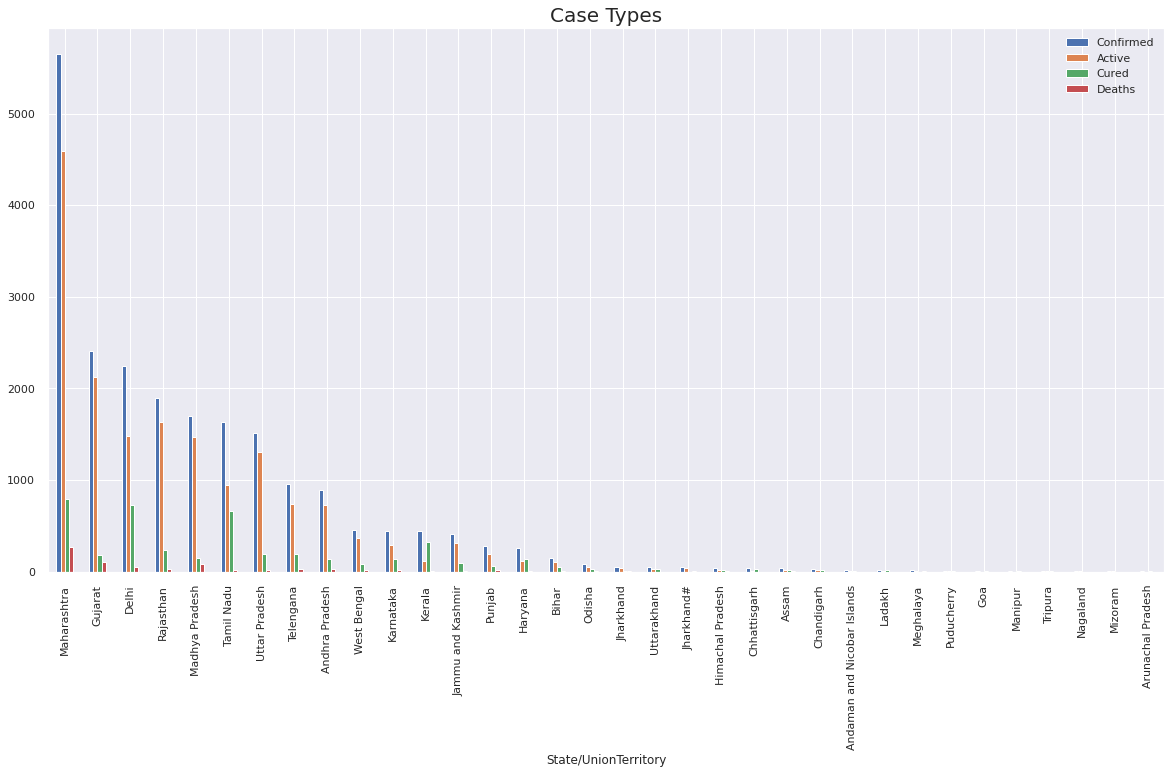

In [44]:
sns.set()
df_temp = india_df.drop(columns=['Sno','Date','Time'],axis=1)
df_temp = df_temp.groupby('State/UnionTerritory').max()
df_temp.drop(index=['Nagaland#','Unassigned'],axis=0,inplace=True)
df_temp['Active'] = df_temp.Confirmed-(df_temp.Cured+df_temp.Deaths)
df_temp = df_temp.sort_values(by='Confirmed', ascending=False)
df_temp[['Confirmed','Active','Cured','Deaths']].plot(kind='bar', figsize = (20,10))
plt.title('Case Types',fontsize=font_size)
#plt.style.use('Solarize_Light2')

In [45]:
df_temp=india_df.groupby('Date').sum().reset_index().sort_values('Date')
df_temp.drop(columns=['Sno','Cured'],inplace=True)
df_temp['CFR(%)'] = (df_temp.Deaths/df_temp.Confirmed)*100
fig = px.line(df_temp,x='Date',y='CFR(%)')
fig.update_layout(title_text='Case Fatality Ratio in %')
fig.show()

In [46]:
df_temp = patient_data.gender.dropna().value_counts().reset_index()
df_temp.columns = ['gender','count']
fig = px.pie(df_temp,values='count',names='gender',
             title='Gender Wise Confirmed Cases',
            color_discrete_sequence=px.colors.sequential.Hot)
fig.show()

In [47]:
sns.set()
testing_df['daily_test_count']=testing_df.totalSamplesTested.diff()
testing_df['daily_positive_count']=testing_df.totalPositiveCases.diff()
fig = go.Figure()
fig.add_trace(go.Bar(x=testing_df.day, y=testing_df.daily_test_count,
              name='Total Samples Tested'))
fig.add_trace(go.Bar(x=testing_df.day, y=testing_df.daily_positive_count,
              name='Total Positive Cases'))
fig.update_layout(title_text='COVID19 Test - Timeline - Daily Test',barmode='stack')
fig.show()

In [48]:
sns.set()
testing_df['Ratio'] = (testing_df.daily_positive_count/testing_df.daily_test_count)*100
fig = px.line(testing_df,x='day',y='Ratio')
fig.update_yaxes(title_text='Postive cases to Total test Ratio')
fig.update_xaxes(title_text='Day')
fig.update_layout(title_text='COVID19 - Positive cases to The Total Test Ratio in %')
fig.show()